In [1]:
import nltk
nltk.download('punkt')
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
import tensorflow as tf

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nadana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('final_150_words.csv')
df.head()

,label,type,clean_content
0,1,reliable,"Healthcare | Wed Nov 0, 0 | 0:0am EST BRIEF-Pl..."
1,1,reliable,Kristina Stewart and Arthur Burton Ward were m...
2,0,fake,The Chairman’s Blog % of readers think this st...
3,1,reliable,Mia Hamm and her longtime teammate Julie Foudy...
4,0,fake,Saul via John Smallman: The Vast Majority of H...


In [3]:
df['clean_content'] = df['clean_content'].str.lower()

In [4]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean_content:
    for j in i:
        list_of_words.append(j)

print('No of total words in data set : ', len(list_of_words))

No of total words in data set :  9008750


In [5]:
# Obtain the total number of unique words (using set())
total_words = len(list(set(list_of_words)))
print('No of unique words in data set : ', total_words)

No of unique words in data set :  879


In [6]:
# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(df.clean_content, df.label, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state= 42)

In [7]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
val_sequences = tokenizer.texts_to_sequences(x_val)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [9]:
padded_train = pad_sequences(train_sequences, maxlen=35, padding='post', truncating='post')
padded_val = pad_sequences(val_sequences, maxlen=35, truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=35, truncating='post')

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential()
embedding_dim = 8 
model.add(Embedding(total_words, output_dim=embedding_dim))
lstm_units = 64  
model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)))

# Dense layers with dropout
dense_units = 64  
model.add(Dense(dense_units, activation='sigmoid'))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           7032      
                                                                 
 bidirectional (Bidirection  (None, 128)               37376     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 52729 (205.97 KB)
Trainable params: 52729 (205.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [11]:
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

In [12]:
# train the model
history = model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 10)

Epoch 1/10


225/225 [==============================] - 17s 53ms/step - loss: 0.3174 - acc: 0.8478 - val_loss: 0.1452 - val_acc: 0.9500
Epoch 2/10
225/225 [==============================] - 13s 57ms/step - loss: 0.1526 - acc: 0.9427 - val_loss: 0.1630 - val_acc: 0.9388
Epoch 3/10
225/225 [==============================] - 13s 58ms/step - loss: 0.1332 - acc: 0.9481 - val_loss: 0.1362 - val_acc: 0.9544
Epoch 4/10
225/225 [==============================] - 13s 59ms/step - loss: 0.1283 - acc: 0.9519 - val_loss: 0.1318 - val_acc: 0.9581
Epoch 5/10
225/225 [==============================] - 13s 60ms/step - loss: 0.1149 - acc: 0.9557 - val_loss: 0.1227 - val_acc: 0.9550
Epoch 6/10
225/225 [==============================] - 15s 65ms/step - loss: 0.1088 - acc: 0.9579 - val_loss: 0.1333 - val_acc: 0.9569
Epoch 7/10
225/225 [==============================] - 14s 62ms/step - loss: 0.1087 - acc: 0.9564 - val_loss: 0.1223 - val_acc: 0.9531
Epoch 8/10
225/225 [==============================] - 15s 68

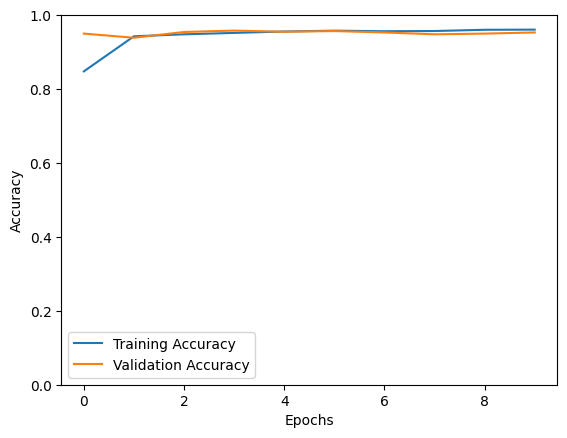

In [22]:
# Plotting training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


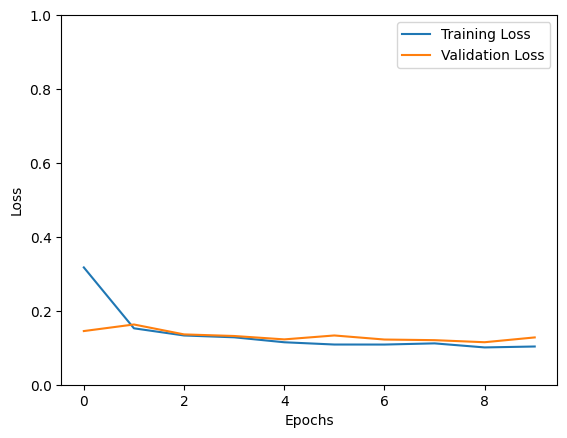

In [21]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.show()

In [15]:
# Make predictions on the test set
pred = model.predict(padded_test)

# If the predicted value is > 0.5, it is real, else it is fake
prediction = [1 if p > 0.5 else 0 for p in pred]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy: ", accuracy)

63/63 [==============================] - 1s 8ms/step
Model Accuracy:  0.9365


[[900  51]
 [ 76 973]]


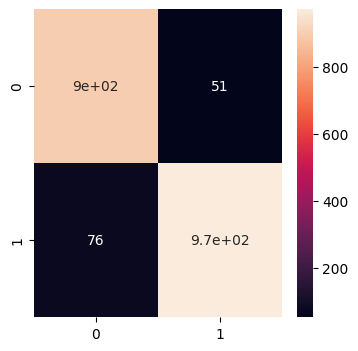

In [16]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
print(cm)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True)
plt.show()


In [17]:
# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(list(y_test), prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       951
           1       0.95      0.93      0.94      1049

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

